<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/influenza/%20ili_and_climate/gene_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.1 MB/s eta 0:00:00


In [2]:
!wget -q "https://huggingface.co/datasets/sidms/sequence_data/resolve/main/sequences%20(4).fasta.gz?download=true" -O "sequences.fasta.gz"

In [3]:
!gunzip sequences.fasta.gz

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import Bio
from Bio import SeqIO
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt


In [5]:
def one_hot_encode_np(seq, max_length=2358):
    # Define a mapping from character to integer index
    char_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    # Initialize a zero matrix of the correct shape
    one_hot = np.zeros((max_length, 4), dtype=np.int8)

    # Truncate sequence if it's too long
    seq = seq[:max_length]

    # Use NumPy's advanced indexing to fill in the 1s
    for i, base in enumerate(seq):
        if base in char_to_int:
            one_hot[i, char_to_int[base]] = 1

    return one_hot
class FastaDataset(Dataset):
    def __init__(self, fasta_file, max_len):
        """
        Reads the FASTA file and stores sequences in a list (in CPU RAM).
        """
        self.sequences = [str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
        self.max_len = max_len
        print(f"Initialized dataset with {len(self.sequences)} sequences.")

    def __len__(self):
        """Returns the total number of sequences in the dataset."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Fetches, encodes, and flattens one sequence when requested.
        This happens on the CPU.
        """
        seq_str = self.sequences[idx]
        one_hot_encoded = one_hot_encode_np(seq_str, self.max_len)
        flattened_seq = one_hot_encoded.cumsum(1).flatten()
        # Return as a CPU tensor. The move to GPU happens later.
        return torch.tensor(flattened_seq, dtype=torch.float32)

In [6]:
# variational Autoencoder

class Encoder(nn.Module):
  def __init__(self, din, hid_size):
    super(Encoder, self).__init__()
    self.din = din
    self.hid_size = hid_size


    self.body = nn.Sequential(
        nn.Linear(din, din // 16),
        nn.ReLU(),
        nn.Linear(din // 16, din // 32),
        nn.ReLU()
    )
    self.mu_layer = nn.Linear(din // 32, hid_size)
    self.logvar_layer = nn.Linear(din // 32, hid_size)



  def forward(self, x):
    x = self.body(x)
    mu = self.mu_layer(x)
    logvar = self.logvar_layer(x)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, din, hid_size):
    super(Decoder, self).__init__()
    self.din = din
    self.hid_size = hid_size


    self.Decode = nn.Sequential(
        nn.Linear(hid_size, din//32),
        nn.ReLU(),
        nn.Linear(din//32, din//16),
        nn.ReLU(),
        nn.Linear(din//16, din),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.Decode(x)



class VAE(nn.Module):
  def __init__(self, din, hid_size):
    super(VAE, self).__init__()
    self.encoder = Encoder(din, hid_size)
    self.decoder = Decoder(din, hid_size)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar


def vaeloss(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return BCE + KLD

In [7]:
fasta_file = 'sequences.fasta'
max_len = 2358
batch_size = 1000


dna_dataset = FastaDataset(fasta_file=fasta_file, max_len=max_len)
train_loader = DataLoader(dataset=dna_dataset, batch_size=batch_size, shuffle=True,)

Initialized dataset with 747881 sequences.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(max_len * 4, 16).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = vaeloss
epochs = 50
bar = tqdm(range(epochs))
for epoch in bar:
    model.train()
    train_loss = 0.0
    batch_bar = tqdm(train_loader, leave=False, desc="Training")
    for data in batch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = criterion(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        batch_bar.set_description(f'Loss: {(loss.item()/1000):.4f}')

    train_loss /= len(train_loader.dataset)
    bar.set_description(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

Training:   0%|          | 0/748 [00:00<?, ?it/s]

In [9]:
# save model weights
torch.save(model.state_dict(), 'vae_weights.pth')

In [12]:
from google.colab import userdata
import pandas as pd
import os
github_token = userdata.get('GITHUB_TOKEN')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/cleaned_data.csv'
filename = 'cleaned_data.csv'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/sequences%20(1).fasta'
filename = 'sequences.fasta'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')

0

In [13]:
records =[]
for record in SeqIO.parse("sequences.fasta", "fasta"):
    records.append({"Accession": record.id.split('.')[0], "Sequence": str(record.seq)})
df = pd.DataFrame(records)
clean_data = pd.read_csv("cleaned_data.csv", index_col=0)
df = df.merge(clean_data, on='Accession', how='inner')

In [15]:
df['Sequence_one_hot'] = df['Sequence'].apply(one_hot_encode_np)

In [16]:
Xt= np.array([np.array(seq) for seq in df['Sequence_one_hot'].values])
Xt= np.array([seq.flatten() for seq in Xt])
Xt = torch.tensor(Xt, dtype=torch.float32)
Xt = Xt.to(device)

In [17]:
with torch.no_grad():
  Xt_reconstructed, mu, logvar = model(Xt)
  latent = model.reparameterize(mu, logvar)
latent = latent.cpu().numpy()
df['Latent'] = latent.tolist()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



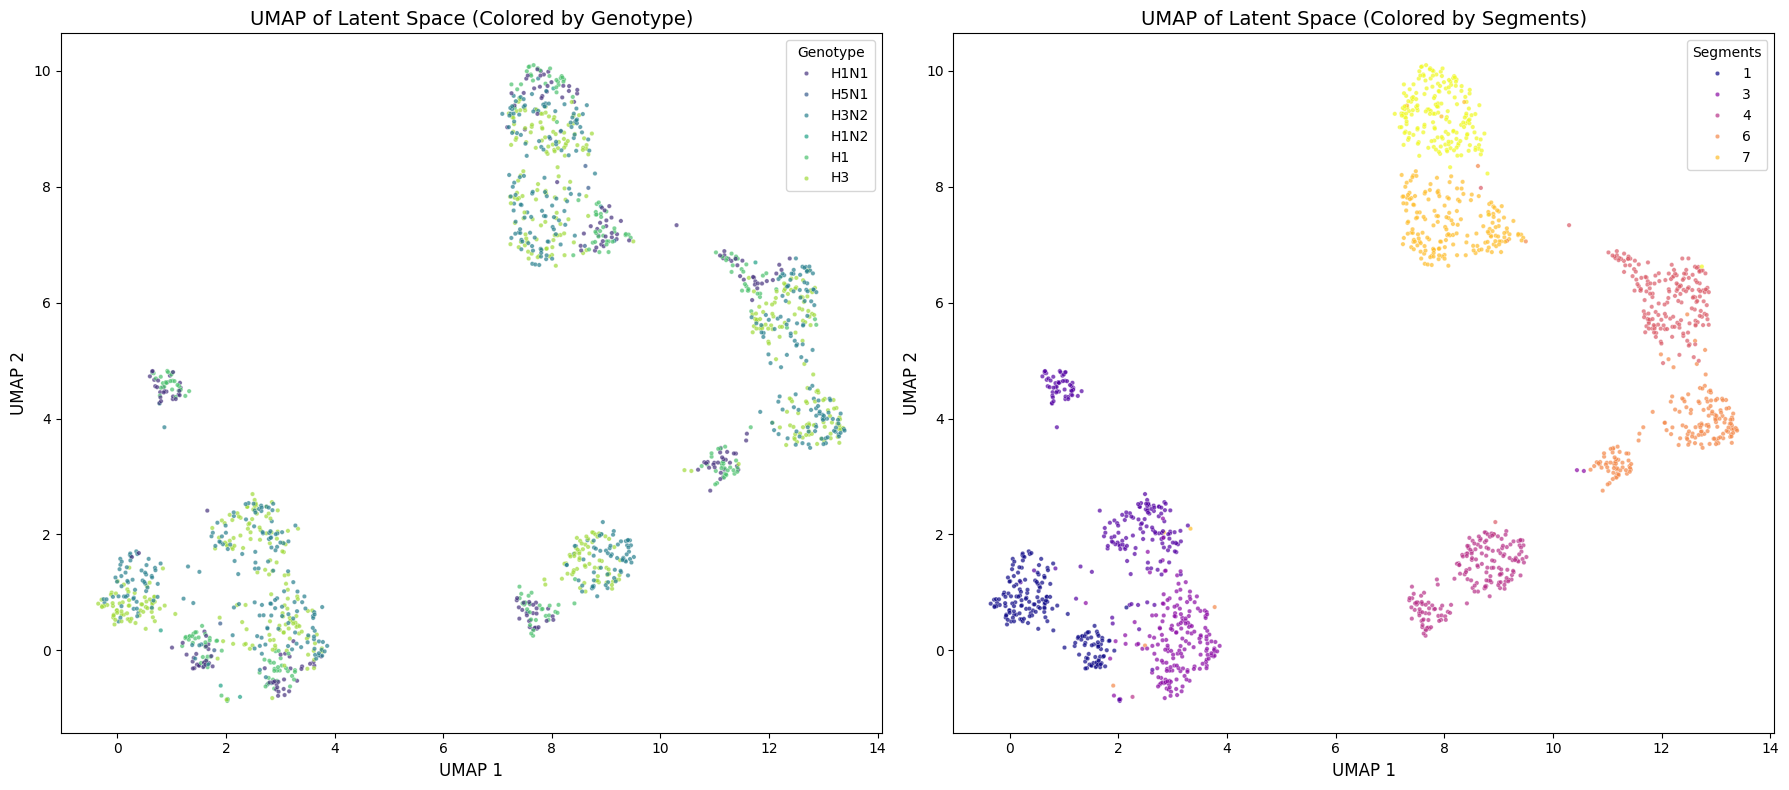

In [26]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns

# UMAP reduction
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='manhattan', random_state=42)
embedding = reducer.fit_transform(latent)

# Add UMAP coordinates to DataFrame
df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]


# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot with Genotype label
sns.scatterplot(ax=axes[0], x='UMAP_1', y='UMAP_2', hue='Genotype', data=df, s=10, palette='viridis', alpha=0.7)
axes[0].set_title('UMAP of Latent Space (Colored by Genotype)', fontsize=14)
axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].legend(title='Genotype')

# Plot with Segments label
sns.scatterplot(ax=axes[1], x='UMAP_1', y='UMAP_2', hue='Segment', data=df, s=10, palette='plasma', alpha=0.7)
axes[1].set_title('UMAP of Latent Space (Colored by Segments)', fontsize=14)
axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].legend(title='Segments', )

plt.tight_layout()
plt.show()

In [29]:
# 3d umap plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

reducer = umap.UMAP(n_neighbors=15, n_components=3, metric='manhattan', random_state=24)
embedding = reducer.fit_transform(latent)

df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]
df['UMAP_3'] = embedding[:, 2]

fig = px.scatter_3d(df, x='UMAP_1', y='UMAP_2', z='UMAP_3', symbol='Genotype', color='Segment')


fig.update_layout(
    title='3D UMAP of Latent Space (Colored by Genotype and Segment)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [36]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

reducer = umap.UMAP(n_neighbors=16, n_components=3, metric='euclidean', random_state=24)
embedding = reducer.fit_transform(latent)

df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]
df['UMAP_3'] = embedding[:, 2]

fig = px.scatter_3d(df, x='UMAP_1', y='UMAP_2', z='UMAP_3', symbol='Genotype', color='Segment')


fig.update_layout(
    title='3D UMAP of Latent Space (Colored by Genotype and Segment)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

